In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
#import src.visuals as vs
from matplotlib import pyplot as plt
#from IPython.display import display # Allows the use of display() for DataFrames
from scipy.stats import norm
# Import supplementary visualizations code visuals.py
import lightgbm as lgb
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from lightgbm.sklearn import LGBMClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score,fbeta_score,make_scorer,roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
import pickle

from sklearn.externals import joblib
seed = 3

/Users/dwightliu/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Users/dwightliu/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip instal

In [2]:
bc = pd.read_csv('data/branded_content_events.csv')
ai = pd.read_csv('data/app_install_events.csv')
ck = pd.read_csv('data/checkout_events.csv')

### data quality check

In [3]:
bc.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024077 entries, 0 to 2024076
Data columns (total 4 columns):
platform         2024077 non-null object
campaign_name    2024077 non-null object
event_time       2024077 non-null int64
uid              2024077 non-null object
dtypes: int64(1), object(3)
memory usage: 61.8+ MB


In [4]:
bc['event_date_time'] = pd.to_datetime(bc['event_time'],unit='s')

In [5]:
bc = bc.drop_duplicates()

In [7]:
bc['evet_dow'] = bc['event_date_time'].dt.dayofweek

In [8]:
ad_cnt = bc.groupby('event_date_time')['uid'].count().reset_index().sort_values(by='event_date_time')

/Users/dwightliu/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Number of uid')

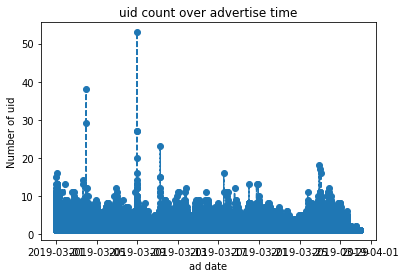

In [10]:
plt.plot(ad_cnt['event_date_time'],ad_cnt['uid'],'o--')
plt.title('uid count over advertise time')
plt.xlabel('ad date')
plt.ylabel('Number of uid')

Text(0, 0.5, 'Number of ads')

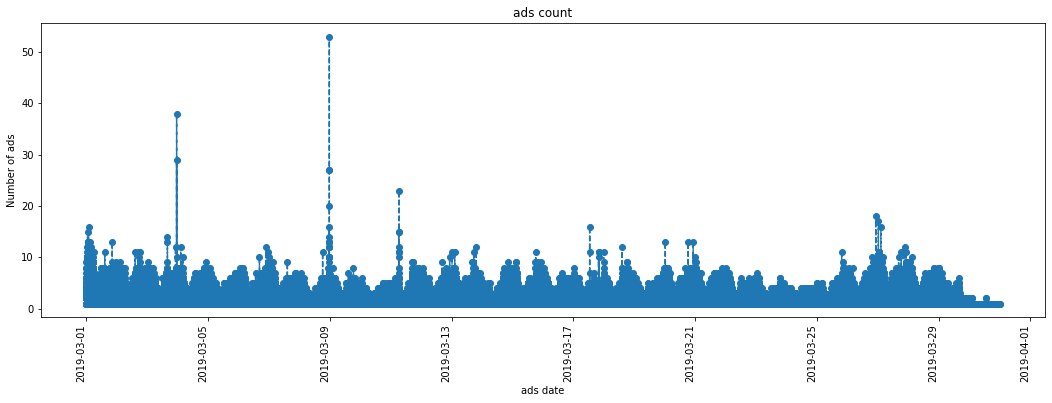

In [11]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(ad_cnt['event_date_time'],ad_cnt['uid'],'o--')
ax.set_title('ads count')
ax.set_xlabel('ads date')
fig.autofmt_xdate(rotation=90)
#plt.xticks(x, labels, rotation='vertical')
ax.set_ylabel('Number of ads')

In [ ]:
bc.head()

In [20]:
bc['platform'].value_counts()

iPhone     1381740
Android     641678
Name: platform, dtype: int64

In [18]:
top_5_list = bc['campaign_name'].value_counts().nlargest(5).index.tolist()

In [19]:
bc['campaign_name'] = np.where(bc['campaign_name'].isin(top_5_list),bc['campaign_name'],'non_top_5')

In [ ]:
sign_week_perf = bc.groupby(['day_of_week'],as_index=False)['target'].mean()
fig, ax = plt.subplots()
plt.bar(sign_week_perf['day_of_week'], sign_week_perf['target'])

In [ ]:
bc['uid'].nunique()

In [ ]:
bc[['uid','campaign_name','platform']].drop_duplicates().shape

In [ ]:
bc = bc.sort_values(by='event_time').drop_duplicates(subset=['uid','campaign_name','platform'], keep='last')

In [ ]:
ai.info(null_counts=True)

In [ ]:
ai = ai.drop_duplicates()

In [ ]:
ai.info(null_counts=True)

In [ ]:
ai['source'].value_counts()

In [ ]:
ai_uid_null = ai[ai['uid'].isnull()]

In [ ]:
ai_uid_null['source'].value_counts()

In [ ]:
ai['']

In [ ]:
ck.info(null_counts=True)

In [ ]:
'''
#Business goal
We want to expand the spend on the sponsored content strategy while maintaining a level of efficiency. 

#The Questions

-	What can you tell us about the effectiveness of our ad campaigns in terms of generating paid subscriptions?
-	What is our general time to acquisition from seeing the ad to getting a paid subscriber? (Assume trial conversion always takes exactly 7 days)
-	What are the factors that affect the conversion rate to a paid subscription and what do you think that tells us about these visitors?

#Additional Discussion
-	What would you recommend the performance marketing manager do? What would you recommend the product manager do? 
-	What additional information would make this analysis more “complete” or actionable? If given that information and more time, how would that change your analysis?
'''